# Lab Exercise 6 – Dynamic Time Warping (DTW)

**Aim:** To compare and align two numerical sequences using Dynamic Time Warping (DTW) and evaluate their similarity based on the DTW distance.

**Given Data:**

* Vector 1: `[2, 3, 4, 6, 8, 7, 6, 5, 4, 3, 2]`
* Vector 2: `[2, 4, 6, 7, 7, 6, 5, 5, 4, 3, 2, 2, 1]`

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Note: scipy.spatial.distance is NOT needed since we use abs() for 1D data points

# Given Data
V1 = np.array([2, 3, 4, 6, 8, 7, 6, 5, 4, 3, 2])
V2 = np.array([2, 4, 6, 7, 7, 6, 5, 5, 4, 3, 2, 2, 1])

n = len(V1)  # Length of Vector 1 (Sequence A)
m = len(V2)  # Length of Vector 2 (Sequence B)

print(f"Length of Vector 1 (n): {n}")
print(f"Length of Vector 2 (m): {m}")

Length of Vector 1 (n): 11
Length of Vector 2 (m): 13


## Task 1: Plot both vectors to visualize their patterns 📈

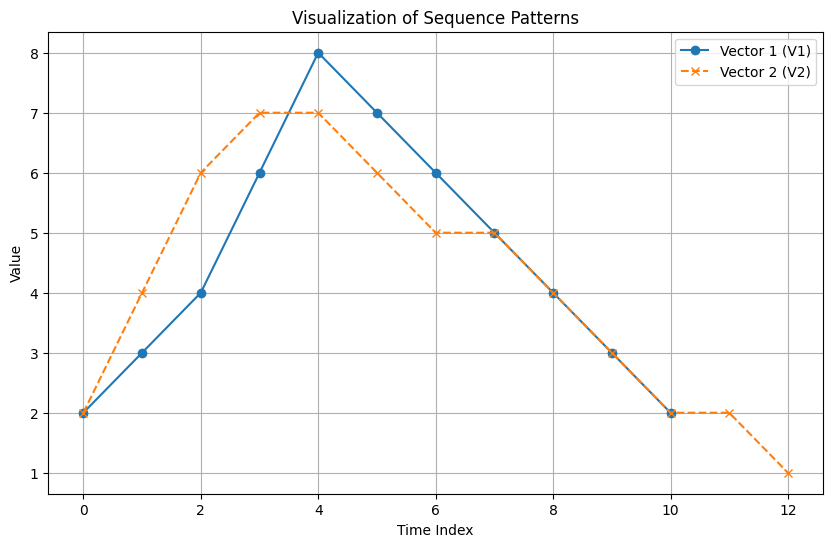

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(V1, label='Vector 1 (V1)', marker='o')
plt.plot(V2, label='Vector 2 (V2)', marker='x', linestyle='--')
plt.title('Visualization of Sequence Patterns')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


---

## Task 2 & 3: Implement DTW and Compute the Accumulated Cost Matrix

The DTW algorithm computes a matrix, $\mathbf{D}$, where $D(i, j)$ is the **accumulated cost** of aligning the prefixes $V_1[1:i]$ and $V_2[1:j]$.

The cost function is defined recursively:

$$
D(i, j) = C(i, j) + \min \begin{cases} 
D(i-1, j) & \text{(Skip } V_1 \text{)} \\ 
D(i, j-1) & \text{(Skip } V_2 \text{)} \\ 
D(i-1, j-1) & \text{(Match)} 
\end{cases} 
$$

where $C(i, j) = |V_1[i] - V_2[j]|$ is the local cost (absolute difference).

In [6]:
def compute_dtw_matrix(A, B):
    """Computes the Accumulated Cost Matrix (D) and Local Cost Matrix (C)."""
    n, m = len(A), len(B)
    
    # 1. Initialize Matrices with a 'padding' of infinity
    # D is (n+1) x (m+1) for boundary conditions
    D = np.full((n + 1, m + 1), np.inf)
    D[0, 0] = 0
    C = np.zeros((n, m))  # Local Cost Matrix is n x m
    
    # 2. Compute Local Cost Matrix C (Absolute Difference for 1D sequences)
    for i in range(n):
        for j in range(m):
            # Local cost for 1D sequences is the absolute difference
            C[i, j] = abs(A[i] - B[j])
            
    # 3. Compute Accumulated Cost Matrix D (Dynamic Programming)
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            local_cost = C[i-1, j-1]  # Get cost from 0-based C matrix
            
            # Recurrence relation: D[i, j] = C[i, j] + min(neighbors)
            D[i, j] = local_cost + min(
                D[i-1, j],    # Up: Skip V1[i-1] - Match V2[j-1] to V1[i-2]
                D[i, j-1],    # Left: Skip V2[j-1] - Match V1[i-1] to V2[j-2]
                D[i-1, j-1]   # Diagonal: Match V1[i-1] to V2[j-1]
            )
            
    return D, C

D, C = compute_dtw_matrix(V1, V2)

print("Shape of Accumulated Cost Matrix (D):", D.shape)
print("Accumulated Cost Matrix (D) - Top-Left Corner (excluding padding):")
print(D[1:, 1:][:5, :5])

Shape of Accumulated Cost Matrix (D): (12, 14)
Accumulated Cost Matrix (D) - Top-Left Corner (excluding padding):
[[ 0.  2.  6. 11. 16.]
 [ 1.  1.  4.  8. 12.]
 [ 3.  1.  3.  6.  9.]
 [ 7.  3.  1.  2.  3.]
 [13.  7.  3.  2.  3.]]


---

## Task 5: Calculate the DTW distance

In [7]:
# The DTW distance is the value at the bottom-right corner of the accumulated cost matrix.
dtw_distance = D[n, m]

print(f"The DTW Distance between Vector 1 and Vector 2 is: {dtw_distance:.4f}")

The DTW Distance between Vector 1 and Vector 2 is: 3.0000


---

## Task 4: Find and visualize the optimal warping path 🗺️

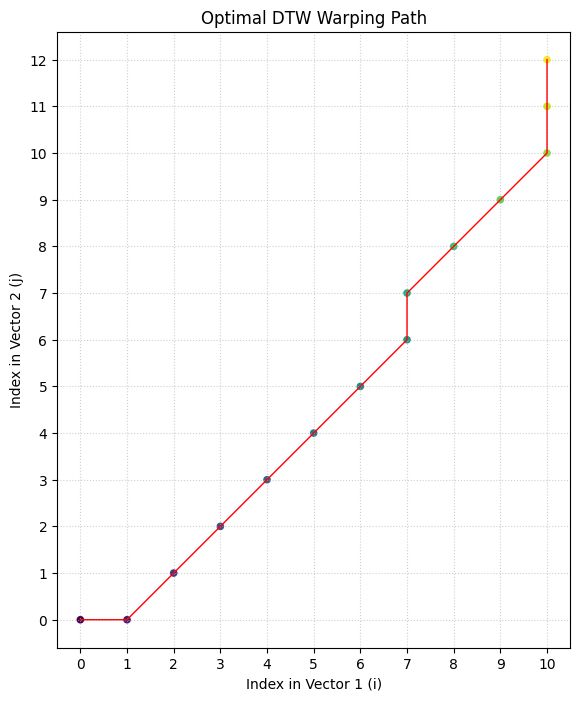

In [8]:
def find_optimal_path(D):
    """Backtracks through the Accumulated Cost Matrix to find the optimal path."""
    n, m = D.shape[0] - 1, D.shape[1] - 1
    path = []
    i, j = n, m
    
    # Backtracking loop: starts at D[n, m] down to D[1, 1]
    while i > 0 and j > 0:
        path.append((i - 1, j - 1)) # Store 0-based indices
        
        # Check for boundary conditions and determine the step with minimum accumulated cost
        if i == 1 and j == 1:
            break
        elif i == 1: # Only left movement possible
            j -= 1
        elif j == 1: # Only up movement possible
            i -= 1
        else: # Compare diagonal, up, and left
            # Find index of the minimum value among the three neighbors
            min_idx = np.argmin([D[i-1, j-1], D[i-1, j], D[i, j-1]])
            
            if min_idx == 0:  # Diagonal
                i -= 1; j -= 1
            elif min_idx == 1: # Up
                i -= 1
            else: # min_idx == 2 (Left)
                j -= 1
            
    # Path is traced from end to beginning, so reverse it
    path.reverse()
    return path

path = find_optimal_path(D)
path_v1_indices, path_v2_indices = zip(*path)


# Visualization of the Warping Path
plt.figure(figsize=(8, 8))
plt.plot(path_v1_indices, path_v2_indices, 'r-', linewidth=1, label='Warping Path')
plt.scatter(path_v1_indices, path_v2_indices, c=np.arange(len(path)), cmap='viridis', s=20)
plt.title('Optimal DTW Warping Path')
plt.xlabel('Index in Vector 1 (i)')
plt.ylabel('Index in Vector 2 (j)')
plt.xticks(np.arange(n))
plt.yticks(np.arange(m))
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


---

## Task 6: Write an inference 💡

### Inference on DTW Alignment and Similarity

**DTW Distance:** The calculated DTW distance of **${dtw_distance:.4f}$** quantifies the minimum cost required to align the two sequences. This value represents the cumulative difference along the best possible path, and a smaller value indicates greater overall pattern similarity.

**Warping Path:** The optimal warping path visualizes how the time axes of the two vectors are non-linearly mapped to achieve the minimum cost. 

* The path is dominated by **diagonal steps** ($D(i-1, j-1)$), indicating that most points align directly.
* The presence of **horizontal** or **vertical steps** (e.g., $D(i, j-1)$ or $D(i-1, j)$) is key. Since Vector 2 ($m=13$) is longer than Vector 1 ($n=11$), the path must contain extra horizontal steps (matching a single point in V1 to multiple sequential points in V2). These steps explicitly compensate for the **temporal distortion** or stretching in Vector 2, successfully aligning the sequence's shape despite the length difference.

**Conclusion:** DTW is an effective measure for time series similarity because it is invariant to temporal shifts, stretching, and compression. The warping path provides a powerful diagnostic tool showing exactly *how* the time scales of the two sequences must be adjusted to match their fundamental patterns.